# Transporting Inferences

In this notebook, we cover transporting inferences between different domains.

We consider a scenario where we perform an observational study measuring participant ratings of decision support systems in China, and we also have information about receptiveness to robot-issued decision support in the United States. Using this data, we want to estimate participant ratings of decision support in the United States.

* Treatment (A): Decision support system type (0: computer-issued; 1: robot-issued)
* Confounder (C): Receptiveness to robot-issued decision support, on a scale of 0-4
* Outcome (Y): Rating of decision support system, on a scale of 0-4

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from causal_hri import data
from causal_hri import estimators

We generate the source data from the Chinese domain. We collect data $(A_i, C_i, Y_i)_{i=1}^N$ corresponding to the treatment, confounder, and outcome, respectively, from an observational study.

In [2]:
N = 500
df_c = data.generate_transportability_dataset(N=N, domain="China")

In [3]:
df_c.mean()

decision_system    0.868
receptiveness      1.004
rating             3.416
dtype: float64

We generate the full target data from the American domain, but in the transportable estimator, we will only use the information about the confounder (receptiveness to robotic recommendation), as if we had conducted a survey collecting only that information. This is represented by $(C_i)_{i=1}^N$.

In [4]:
df_u = data.generate_transportability_dataset(N=N, domain="US")

In [5]:
df_u.mean()

decision_system    0.930
receptiveness      1.944
rating             3.740
dtype: float64

The population causal effect of the decision support system on participant rating in the United States is 
$$p^*(Y(a)) = \sum_C p(Y | A, C) p^*(C) $$
where distributions $p( \cdot)$ are drawn from China, and $p^*(\cdot)$ are drawn from the United States.

We can estimate the causal effect by
$$E[Y(a)] = \frac{1}{N}\sum_{i=1}^N \hat{E}[Y | A=a, C=C'_i]$$ 

where $\hat{E}$ is formed by training on data $(A_i, C_i, Y_i)$ from China but is then evaluated at a fixed value of $A$ and confounder data $C'_i$ from the United States. We will call this the _transported estimate_.

We can compare this estimate to an estimate computed on the full target data $(A'_i, C'_i, Y'_i)$ which represents the full data collected from an observational study conducted in the United States. In this estimate, we simply adjust for the confounding using the g-formula. We will call this the _target estimate_.

In [6]:
n_bootstraps = 100

transported = []
target = []
for i in range(n_bootstraps):
    df_u_sample = df_u.sample(frac=1, replace=True)
    df_c_sample = df_c.sample(frac=1, replace=True)
    est_transport = estimators.estimate_g_formula_transportable(data_source=df_c_sample, data_target=df_u_sample[["receptiveness"]], outcome="rating",
                                           treatment="decision_system", treatment_value=1, confounders=["receptiveness"]) - estimators.estimate_g_formula_transportable(data_source=df_c_sample, data_target=df_u_sample[["receptiveness"]], outcome="rating",
                                           treatment="decision_system", treatment_value=0, confounders=["receptiveness"])
    transported.append(est_transport)
    est_target = estimators.estimate_g_formula(data=df_u_sample, outcome="rating",
                                           treatment="decision_system", treatment_value=1, confounders=["receptiveness"]) - estimators.estimate_g_formula(data=df_u_sample, outcome="rating",
                                           treatment="decision_system", treatment_value=0, confounders=["receptiveness"])
    target.append(est_target)

In this simulation, the true average causal effect is about 0.8. We see that both estimators (transported and target) recover this causal effect well. 

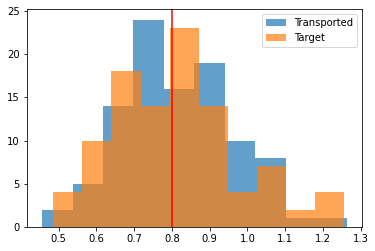

In [8]:
plt.hist(transported, label="Transported", alpha=.7)
plt.hist(target, label="Target", alpha=.7)
plt.axvline(0.8, color='red')
plt.legend()